## **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
import json
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers


In [2]:
#Load dataset
df = pd.read_excel('data.xlsx')

df.head()


,Source,Date,Text,Category,Polarity
0,BBC Bangla,2018-06-03 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,other,positive
1,BBC Bangla,2018-06-04 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,team,positive
2,BBC Bangla,15/6/2017,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,team,positive
3,BBC Bangla,15/6/2020,সৌম্যকে বাদ দেওয়া হোক,batting,negative
4,BBC Bangla,27/1/2018,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",team,positive


In [3]:
#Show total columns
df.columns

Index(['Source', 'Date', 'Text', 'Category', 'Polarity'], dtype='object')

In [4]:
#Drop the unnecessary colums
df = df.drop(['Source', 'Date','Category'], axis=1)

In [5]:
df.head()


,Text,Polarity
0,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive
1,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive
2,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,positive
3,সৌম্যকে বাদ দেওয়া হোক,negative
4,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",positive


In [6]:
df.describe()

,Text,Polarity
count,2979,2979
unique,2720,3
top,"এই পিচে বাংলাদেশকে ৪র্থ ইনিংসে ব্যাট করতে হবে,...",negative
freq,4,2152


In [7]:
#show total numbers of pos,neg and neutral comments
print("Total Reviews:",len(df),
      "\nTotal Positive Reviews:",len(df[df.Polarity =='positive']),
      "\nTotal Negative Reviews:",len(df[df.Polarity=='negative']),
      "\nTotal Neutral Reviews:",len(df[df.Polarity =='neutral']))

Total Reviews: 2979 
Total Positive Reviews: 566 
Total Negative Reviews: 2152 
Total Neutral Reviews: 261


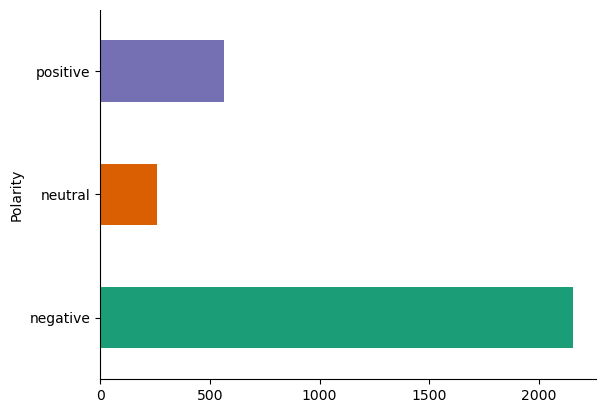

In [8]:
#visualize the data
df.groupby('Polarity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
from plotly import graph_objs as go
temp = df.groupby('Polarity').count()['Text'].reset_index().sort_values(by='Text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Polarity,Text
0,negative,2152
2,positive,566
1,neutral,261


In [10]:
df.sample(n=5, random_state=0)[['Text', 'Polarity']]


,Text,Polarity
2671,মাসরাফি আর ভারতীয় লিজেন্ড জহির খাঁন এর উইকেট ই...,positive
538,অবহেলিত মমিনুল জন্য আজ এই টেষ্ট ড্র করতে পারলাম,positive
1628,বাংলাদেশের আবাল ক্রীড়া সাংবাদিক দের মাঠে নামায়...,negative
1412,এখন টেস্ট ও একি দশা। বাকি রইলো টি২০!,negative
1725,"আমাদের শান্তনা দুজন বোলার ৪ উইকেট পাইছে,এটা নি...",negative


In [14]:
#showing some random comments and their sentiments
sample_data = [10,100,250,650]
for i in sample_data:
      print(df.Text[i],'\n','Sentiment:-- ',df.Polarity[i],'\n')

,আমার বাংলাদেশ জিদবে #$ @ ইনশা আল্লাহ।। 
 Sentiment:--  positive 

ধন্যবাদ রাজ্জাককে সুযোগ দেওয়ার জন্য। 
 Sentiment:--  positive 

 আসেন এখন আমরা বাংলাদেশ টিমরে গাইলাই 
 Sentiment:--  negative 

 আরো আগে রাজ্জাকের প্রত্যাবর্তন করা দরকার ছিল 
 Sentiment:--  positive 



## **Data Preprocessing**

In [15]:
#Data Cleaning
def process_text(Text):
    Text = re.sub('[^\u0980-\u09FF]',' ',str(Text)) #removing unnecessary punctuation
    Text = re.sub('[?.`*^()!°¢܌Ͱ̰ߒנ~×Ҡߘ:ҰߑÍ|।;!,&%\'@#$><A-Za-z0+-9=./''""_০-৯]', '', str(Text))
    Text = re.sub(r'(\W)(?=\1)', '', str(Text))
    Text = re.sub(r'https?:\/\/.*[\r\n]*', '', str(Text), flags=re.MULTILINE)
    Text = re.sub(r'\<a href', ' ', str(Text))
    Text = re.sub(r'&amp;', '', str(Text))
    Text = re.sub(r'<br />', ' ', str(Text))
    Text = re.sub(r'\'', ' ', str(Text))
    Text = re.sub(r'ߑͰߑ̰ߒנ', '', str(Text))
    Text = re.sub(r'ߎɰߎɰߎɍ', '', str(Text))
    #pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('bengali')) + r')\b\s*')
    #Text = pattern.sub('', Text)
    return Text

In [16]:
# Apply the function into the dataframe
df['cleaned'] = df['Text'].apply(process_text)

# print some cleaned reviews from the dataset
sample_data = [10,100,250]
for i in sample_data:
     print('Original:\n',df.Text[i],'\nCleaned:\n',
           df.cleaned[i],'\n','Textiment:-- ',df.Polarity[i],'\n')

Original:
 ,আমার বাংলাদেশ জিদবে #$ @ ইনশা আল্লাহ।। 
Cleaned:
  আমার বাংলাদেশ জিদবে ইনশা আল্লাহ  
 Textiment:--  positive 

Original:
 ধন্যবাদ রাজ্জাককে সুযোগ দেওয়ার জন্য। 
Cleaned:
 ধন্যবাদ রাজ্জাককে সুযোগ দেওয়ার জন্য  
 Textiment:--  positive 

Original:
  আসেন এখন আমরা বাংলাদেশ টিমরে গাইলাই 
Cleaned:
  আসেন এখন আমরা বাংলাদেশ টিমরে গাইলাই 
 Textiment:--  negative 



Removing Low-length data


In [17]:
Positive_sent = df[df['Polarity']=='positive']
Negative_sent = df[df['Polarity']=='negative']
Neutral_sent = df[df['Polarity']=='neutral']

Taking only positive and Negative data

In [18]:
Positive = df[df.Polarity == 'positive']
Negative = df[df.Polarity == 'negative']
df = pd.concat([Positive, Negative], ignore_index=True)
df.Polarity.value_counts()

Polarity
negative    2152
positive     566
Name: count, dtype: int64

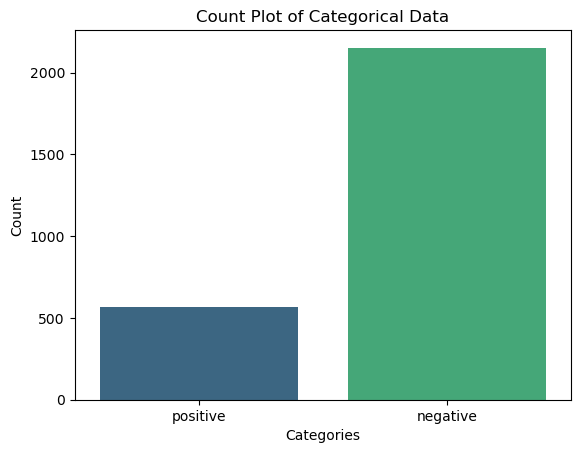

In [19]:
# visualizing positive and negative data
sns.countplot(x='Polarity', data=df, palette='viridis')
plt.title('Count Plot of Categorical Data')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

#### Convert polarity into numerical value


In [20]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Polarity'])

In [21]:
df['labels']=y

In [22]:
df

,Text,Polarity,cleaned,labels
0,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive,জয় বাংলা কাপ তাও আবার স্বাধীনতার মাস মার্চে যা...,1
1,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,positive,জয় বাংলা কাপ তাও আবার স্বাধীনতার মাস মার্চে যা...,1
2,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,positive,বাংলাদেশের পরে ভারতের সাপর্ট ই করি,1
3,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",positive,প্রথমটি হচ্ছে কোচ অত পর সাকিব সাকিব আর সাকিবরে...,1
4,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",positive,প্রথমটি হচ্ছে কোচ অত পর সাকিব সাকিব আর সাকিবরে...,1
...,...,...,...,...
2713,নির্বাচকমণ্ডলী দের গালে জুতা মারা উচিত.. হালা...,negative,নির্বাচকমণ্ডলী দের গালে জুতা মারা উচিত হালার ...,0
2714,"বস ভাল করবে ইটাই আশা করি,দারুন এরজন ব্যাটিং অল...",negative,বস ভাল করবে ইটাই আশা করি দারুন এরজন ব্যাটিং অল...,0
2715,"বস ভাল করবে ইটাই আশা করি,দারুন এরজন ব্যাটিং অল...",negative,বস ভাল করবে ইটাই আশা করি দারুন এরজন ব্যাটিং অল...,0
2716,গুগল সার্চ করে মিনহাজের রানরেট দেখে নিন? এভারে...,negative,গুগল সার্চ করে মিনহাজের রানরেট দেখে নিন এভারেজ...,0


In [23]:
train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
training_cleaned = []
testing_cleaned = []



train_cleaned=train1['cleaned'].values
train_labels=train1['labels'].values
for i in range(train_cleaned.shape[0]): 
    #print(train_sentences[i])
    x=str(train_cleaned[i])
    training_cleaned.append(x)
    
training_cleaned=np.array(training_cleaned)





test_cleaned=test1['cleaned'].values
test_labels=test1['labels'].values

for i in range(test_cleaned.shape[0]): 
    x=str(test_cleaned[i])
    testing_cleaned.append(x)
    
testing_cleaned=np.array(testing_cleaned)


train_labels=keras.utils.to_categorical(train_labels)


test_labels=keras.utils.to_categorical(test_labels)

In [24]:
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_cleaned.shape))
print("testing_sentences shape: "+str(testing_cleaned.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 2174
Testing Set Length: 544
training_sentences shape: (2174,)
testing_sentences shape: (544,)
train_labels shape: (2174, 2)
test_labels shape: (544, 2)


In [25]:
from sklearn.utils import resample
import pandas as pd

# Combine training data and labels for resampling
train_combined = pd.concat([pd.DataFrame(training_cleaned), pd.DataFrame(train_labels.argmax(axis=1))], axis=1)
train_combined.columns = ['cleaned', 'labels']

# Separate the majority and minority classes
majority_class = train_combined[train_combined['labels'] == train_combined['labels'].mode()[0]]
minority_class = train_combined[train_combined['labels'] != train_combined['labels'].mode()[0]]

# Oversample the minority class
minority_class_oversampled = resample(minority_class, 
                                      replace=True,       # Sample with replacement
                                      n_samples=len(majority_class),  # Match majority class size
                                      random_state=42)    # For reproducibility

# Combine majority class with oversampled minority class
train_oversampled = pd.concat([majority_class, minority_class_oversampled])

# Shuffle the new dataset
train_oversampled = train_oversampled.sample(frac=1, random_state=42)

# Update training data and labels
training_cleaned = train_oversampled['cleaned'].values
train_labels = keras.utils.to_categorical(train_oversampled['labels'].values)



In [26]:
import numpy as np

# If train_labels is one-hot encoded, convert it back to categorical labels first:
if train_labels.ndim == 2:  # checking if it's one-hot encoded
    train_labels_categorical = np.argmax(train_labels, axis=1)
else:
    train_labels_categorical = train_labels

# Get unique labels and their counts
unique_labels, counts = np.unique(train_labels_categorical, return_counts=True)

# Display the labels and their respective counts
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")


Label 0: 1728 samples
Label 1: 1728 samples


In [27]:
print(training_cleaned[1])
print(train_labels[0])

 পরাজয় হয়ছি করার কিছু নাই কিন্তু মাএ রানে অলআউট মানতে পারলাম না 
[0. 1.]


In [28]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [29]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_cleaned)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))

sequences = tokenizer.texts_to_sequences(training_cleaned)

padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(testing_cleaned)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)


5693
Word index length:5693


In [30]:
print("Sentence :--> \n")
print(training_cleaned[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

 চাইছিল স্পিনিং উইকেট বানায়া তাদের নাজেহাল করবে 

Sentence Tokenized and Converted into Sequence :--> 

[2840, 1636, 52, 2841, 95, 2842, 169]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 2840 1636   52 2841   95
 2842  169]


In [31]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (3456, 100)
Padded shape(testing): (544, 100)


In [41]:
from tensorflow.keras.layers import Embedding, Conv1D, BatchNormalization, ReLU, Dropout, GlobalMaxPooling1D, Concatenate, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adamax

# Branch 1
branch1 = Sequential()
branch1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
branch1.add(Conv1D(200, kernel_size=3, activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
branch2.add(Conv1D(200, kernel_size=3, activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

# Concatenate outputs from both branches
concatenated = Concatenate()([branch1.output, branch2.output])

# Add hidden layers
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

# Create model
model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)




In [42]:
# Compile model
model.compile(optimizer=Adamax(),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_6_input (InputLa  [(None, 100)]                0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_7_input (InputLa  [(None, 100)]                0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_6 (Embedding)     (None, 100, 300)             7500000   ['embedding_6_input[0][0]']   
                                                                                            

                                                                                                  
 global_max_pooling1d_6 (Gl  (None, 200)                  0         ['dropout_9[0][0]']           
 obalMaxPooling1D)                                                                                
                                                                                                  
 global_max_pooling1d_7 (Gl  (None, 200)                  0         ['dropout_10[0][0]']          
 obalMaxPooling1D)                                                                                
                                                                                                  
 concatenate_3 (Concatenate  (None, 400)                  0         ['global_max_pooling1d_6[0][0]
 )                                                                  ',                            
                                                                     'global_max_pooling1d_7[0][0]
          

In [43]:
# Assuming padded is used for both branches
# Fit model with two inputs (duplicating padded for both branches if needed)
history = model.fit(
    [padded, padded],  # passing the same input to both branches
    train_labels, 
    epochs=10, 
    batch_size=32,
    validation_data=([testing_padded, testing_padded], test_labels), 
    verbose=1,
    use_multiprocessing=True, 
    workers=8
)

Epoch 1/10


108/108 [==============================] - 20s 165ms/step - loss: 0.6723 - accuracy: 0.6933 - precision_3: 0.6933 - recall_3: 0.6933 - val_loss: 0.6844 - val_accuracy: 0.6893 - val_precision_3: 0.6893 - val_recall_3: 0.6893
Epoch 2/10
108/108 [==============================] - 18s 166ms/step - loss: 0.2914 - accuracy: 0.8828 - precision_3: 0.8828 - recall_3: 0.8828 - val_loss: 0.6392 - val_accuracy: 0.8364 - val_precision_3: 0.8364 - val_recall_3: 0.8364
Epoch 3/10
108/108 [==============================] - 18s 164ms/step - loss: 0.1607 - accuracy: 0.9476 - precision_3: 0.9476 - recall_3: 0.9476 - val_loss: 0.5519 - val_accuracy: 0.8401 - val_precision_3: 0.8401 - val_recall_3: 0.8401
Epoch 4/10
108/108 [==============================] - 17s 161ms/step - loss: 0.1087 - accuracy: 0.9682 - precision_3: 0.9682 - recall_3: 0.9682 - val_loss: 0.4628 - val_accuracy: 0.8346 - val_precision_3: 0.8346 - val_recall_3: 0.8346
Epoch 5/10
108/108 [==============================] - 18s 

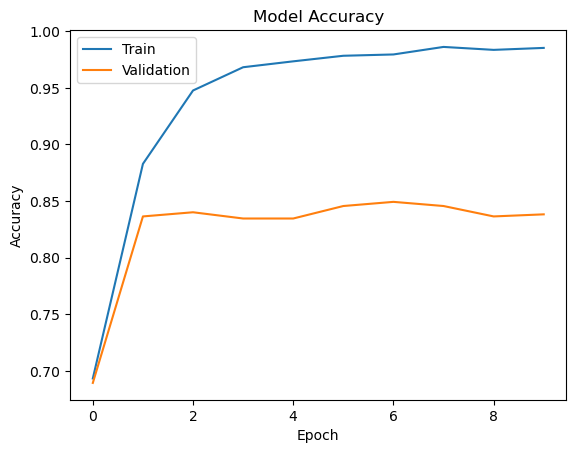

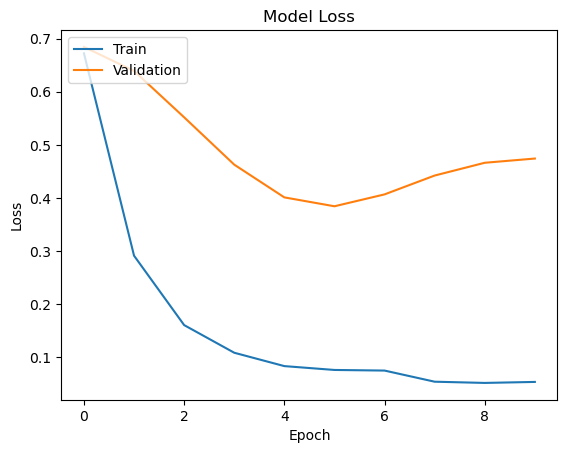

In [44]:
# Plot the accuracy and loss curves to visualize overfitting
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

17/17 [==============================] - 0s 10ms/step
Confusion Matrix:
[[403  21]
 [ 67  53]]


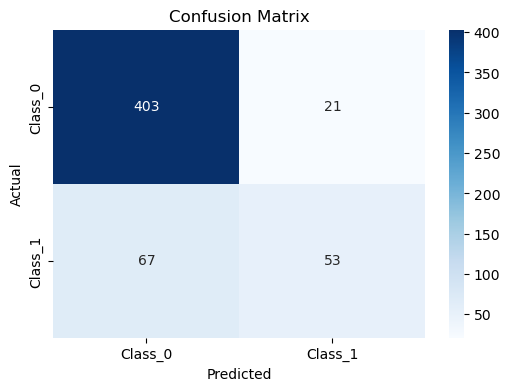

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Make predictions on the test set
y_pred_prob = model.predict([testing_padded, testing_padded])  # Pass both inputs for the model
y_pred_labels = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Step 2: Convert one-hot encoded `test_labels` back to class labels (if necessary)
y_test_labels = np.argmax(test_labels, axis=1)

# Step 3: Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Step 4 (Optional): Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class_0', 'Class_1'], yticklabels=['Class_0', 'Class_1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
